# 예지 보수 Predictive Maintenance (PM)

- 보수의 종류
  > 고장 후 보수: 기기가 고장이 나면 보수를 하는 것   
  > 정기적인 보수: 일정한 시간 간격으로 보수를 하는 것    
  > 예지 보수: 고장을 예측하여 적절한 시점에 보수를 하는 것    
- 예제
 - 항공기 엔진 고장 시점 및 일정 기간내 고장발생 여부 예측
- 랜덤 포레스트와 LSTM 사용
- 참고:[항공기엔진 유지보수 문제](https://gallery.cortanaintelligence.com/Collection/Predictive-Maintenance-Template-3) 

## PM 회귀 모델/분류 모델
- TTF(time to fail): 고장까지 남은 시간을 예측하는 회귀 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.02.12.png?raw=1" align='left'>

## PM 분류 모델 (이진 분류)
- U (Unsafe): TTF가 주어진 경계치 이하로 낮은 위험한 상태
- U 값이 0/1을 갖는 이진 분류 모델로 구현
<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.03.35.png?raw=1" align='left'>

## PM 분류 모델 (다중  분류)
- U (Unsafe): 위험한 상태를 2개 이상으로 분류
- U 값이 0/1/2 세가지를 갖는 다중 분류 모델로 구현

<img src="https://github.com/data-labs/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-02-15%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%2010.45.50.png?raw=1" align='left'>

# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import keras
from keras import Sequential
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMClassifier, LGBMRegressor
from keras.layers import Dropout, LSTM
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report

# 데이터
- 훈련 데이터에는 엔진별 가동 데이터와 수명정보가 있고
- 테스트 데이터에는 엔진 가동 정보만 있고 정답은 (향후 잔여수명)은 별도의 truth 데이터로 제공한다

In [3]:
!wget http://azuremlsamples.azureml.net/templatedata/PM_train.txt 
!wget http://azuremlsamples.azureml.net/templatedata/PM_test.txt
!wget http://azuremlsamples.azureml.net/templatedata/PM_truth.txt 

--2022-07-16 10:18:50--  http://azuremlsamples.azureml.net/templatedata/PM_train.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.70, 13.107.213.70
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘PM_train.txt.2’

PM_train.txt.2      100%[===================>]   3.35M  --.-KB/s    in 0.1s    

2022-07-16 10:18:50 (30.9 MB/s) - ‘PM_train.txt.2’ saved [3515356/3515356]

--2022-07-16 10:18:50--  http://azuremlsamples.azureml.net/templatedata/PM_test.txt
Resolving azuremlsamples.azureml.net (azuremlsamples.azureml.net)... 13.107.246.70, 13.107.213.70
Connecting to azuremlsamples.azureml.net (azuremlsamples.azureml.net)|13.107.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2228855 (2.1M) [text/plain]
Saving to: ‘PM_test.txt.2’

PM_test.txt.2       100%[===================>]   2.

- 컬럼 (변수) 설명
 -	__id__: 엔진 ID (1~100)
 -	__cycle__: 엔진별 운행 시퀀스 번호, (1~ 고장시점 까지)
 -	__setting1__ to __setting3__: 엔진 운영 설정 변수
 -	__s1__ to __s21__: 센서 값


In [4]:
# 훈련 데이터
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [5]:
# 테스트 데이터
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [6]:
# 정답 (테스트데이터의 잔여 수명) 데이터
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [7]:
train_df = train_df.sort_values(['id','cycle'])
train_df[185:195]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
185,1,186,0.0027,-0.0003,100.0,518.67,643.51,1595.16,1426.30,14.62,...,520.08,2388.25,8123.45,8.5227,0.03,397,2388,100.0,38.47,23.0564
186,1,187,-0.0047,-0.0000,100.0,518.67,643.32,1592.10,1427.27,14.62,...,519.53,2388.28,8115.67,8.5218,0.03,396,2388,100.0,38.42,23.0822
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,522.33,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,522.70,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085
194,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,522.58,2387.99,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250


## 레이블(y) 컬럼 추가
- 회귀 분석에서는 잔여시간(TTF)을 예측하며 각 상태(State) 값을 보고 앞으로 남은 잔여시간을 예측하는 회귀 모델을 만든다
- 분류 분석에서는 앞으로 특정 기간 이내에 고장 날지 여부를 예측한다
 - 이진 분류: 예를 들어 30 사이클 이내에 고장 여부를 분류한다 (0/1 구분)
 - 다중 분류: 예를 들어 30 사이클 이내에 고장이 날지 또는 15 사이클 이내 고장이 날지를 나누어 예측한다 (0/1/2 구분)
- 회귀 및 분류를 위한 레이블을 만들겠다

- RUL(Remaining Useful Life)
 - 같은 엔진 ID에 대해서 최대 cycle 값이 "수명"을 나타낸다
 - 이 수명값을 rul 데이터프레임에 저장한다
 - 같은 엔진들 즉 같은 'id'를 같는 행들을 각각 별도의 데이터프레임으로 만드는 groupby를 사용한다

In [8]:
# 모든 행에 대해서 잔여수명 레이블 추가
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


- 각 행별로 잔여 수명 (RUL)은, 각 엔진별 rul 테이블의 수명에서 현재 시각인 cycle 값을 뺀 값이다
- rul 데이터프레임에서 수명을 나타내는 cycle 컬럼 이름을 max라고 바꾸겠다
- 잔여 수명을 나타내는 'RUL' 컬럼을 추가한다

In [9]:
rul

,id,max
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


## 분류용 레이블
- 이진분류를 위해서, 앞으로 30 사이클 이내에 고장이 날 지를 예측하는 이진 분류용 레이블을 만든다
 - bnc (binary classifiation)
- 다중 분류를 위해서, 앞으로 30 및 15 사이클 이내에 고장이 날 지를 구분하는 다중 분류용 레이블을 만든다
 - mcc (multi-class classification)

In [10]:
# 이진분류, 삼진 분류를 위한 레이블
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


## 스케일링
- 모든 센서 값의 최소, 최대 값이 0~1 범위를 갖도록 스케일링한다 
- 스케일링 대상이 아닌 ['id','cycle','ttf','label_bnc','label_mcc'] 컬럼은 제외하기 위해서 difference 함수를 사용한다
- cycle 값을 하나 복사하여 스케일링한다 - 이를 사용할지 여부는 나중에 판단한다


In [11]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


## 테스트 데이터 전처리
- 훈련 데이터에서 사용한 스케일러를 사용한다
 - min_max_scaler.transform()를 사용해야 함

In [12]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


- 정답 데이터를 테스트 데이터에 추가하기 위해서 truth 정보를 이용한다

In [13]:
# 테스트 데이터에 정답 잔여 수명 컬럼을 추가한다
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [14]:
# 각 행별로 잔여수명을 계산한다
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [15]:
test_df.shape

(13096, 28)

In [16]:
# 분류를 위한 레이블 추가
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


# 탐색적 분석

In [17]:
# 훈련 및 테스트 데이터프레임
train_df.shape, test_df.shape

((20631, 30), (13096, 30))

In [18]:
train_df.columns

Index(['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'RUL', 'label1',
       'label2', 'cycle_norm'],
      dtype='object')

In [19]:
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

# 목적변수인 RUL과 상관관계가 큰 순으로 소팅해 본다
train_df[features].corrwith(train_df.RUL).sort_values(ascending=False)

s12         0.671983
s7          0.657223
s21         0.635662
s20         0.629428
setting2   -0.001948
setting1   -0.003198
s6         -0.128348
s14        -0.306769
s9         -0.390102
s13        -0.562569
s8         -0.563968
s3         -0.584520
s17        -0.606154
s2         -0.606484
s15        -0.642667
s4         -0.678948
s11        -0.696228
setting3         NaN
s1               NaN
s5               NaN
s10              NaN
s16              NaN
s18              NaN
s19              NaN
dtype: float64

### 시각화

- 여러 특성의 시계열 변화를 파악하는 함수를 정의한다
- 센서 s에 대해서 랜덤하게 선택한 N개의 엔진 데이터 보기

In [21]:
def plot_time_series(df, s, N):    
    fig, axes = plt.subplots(N, 1, sharex=True, figsize = (8, 8))
    fig.suptitle(s + ' time series / cycle', fontsize=12)
    
    select_engines = np.random.choice(range(1,101), N, replace=False).tolist()
    
    for e_id in select_engines:
        df2 = df[['cycle', s]][df.id == e_id]
        i = select_engines.index(e_id)
        axes[i].plot(df2['cycle'],df2[s])
        axes[i].set_ylabel('engine ' + str(e_id))
        axes[i].set_xlabel('cycle')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

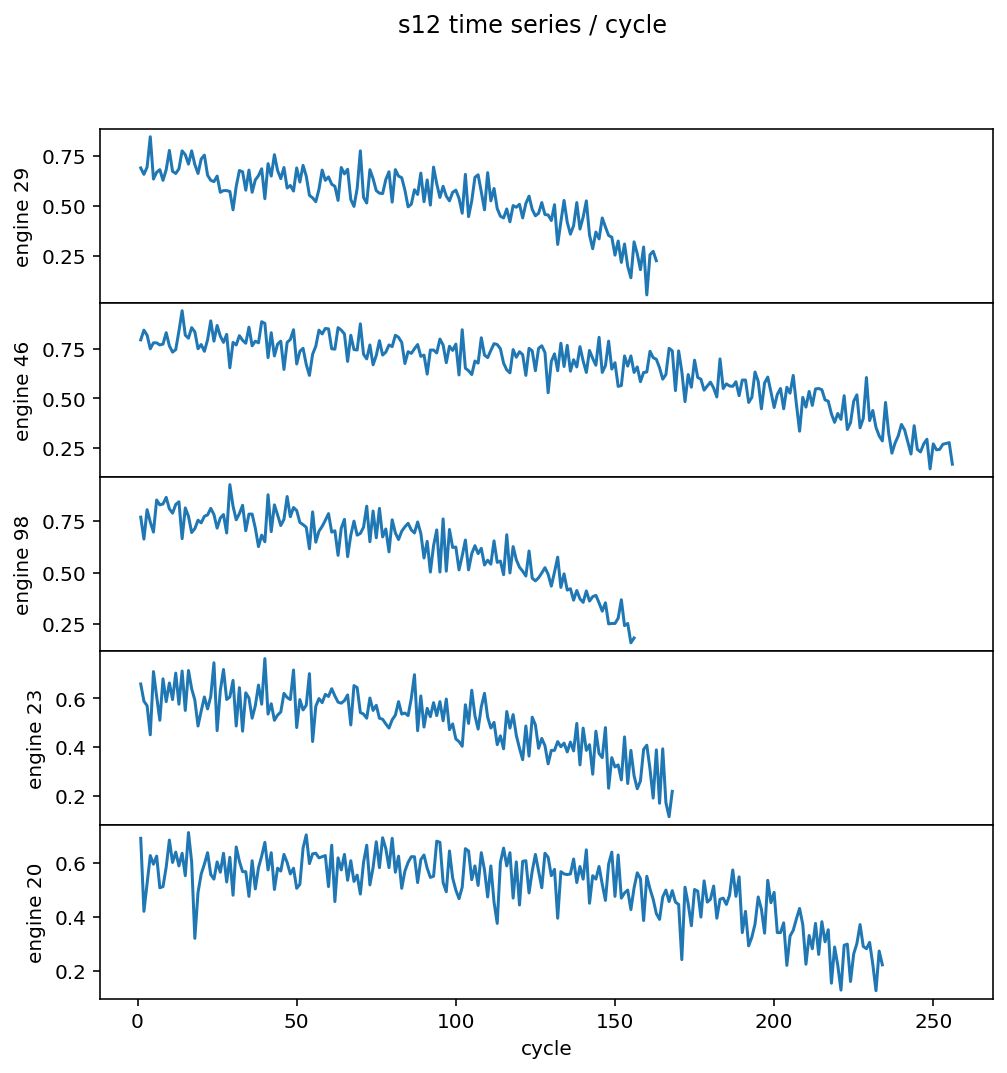

In [22]:
plot_time_series(train_df, 's12',5)

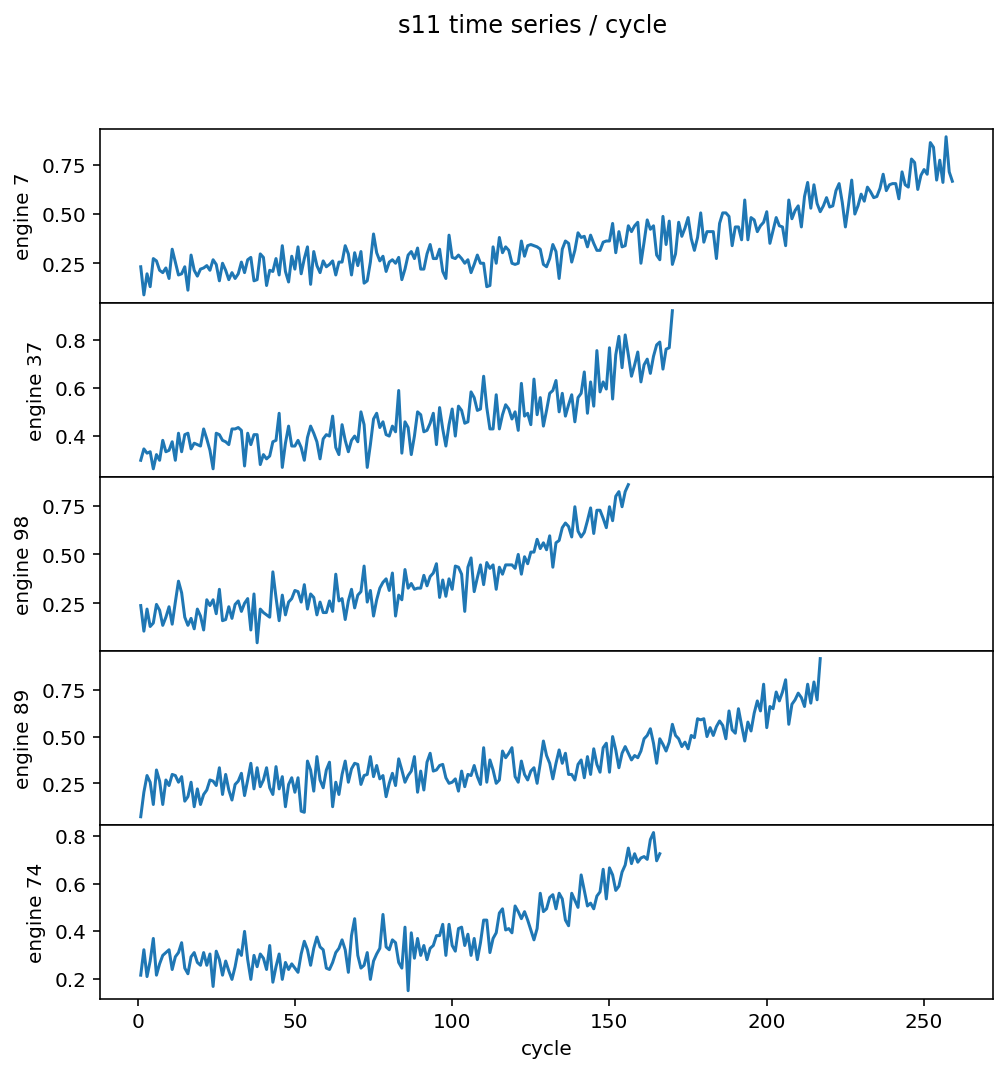

In [23]:
plot_time_series(train_df, 's11',5)

# 랜덤 포레스트 사용

## 회귀모델
- 학습 및 테스트 데이터

In [24]:
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df['RUL']
y_test = test_df['RUL']

In [53]:
def show_regression_result(y_test, y_pred, N=100):
    plt.rc('figure', figsize=(6,4))
    error = y_pred - y_test
    print("MAE=", np.abs(error).mean())
    print("rmse=", np.sqrt((error**2).mean()))
    print("max error=", max(abs(error)))
    print("R2=",r2_score(y_test, y_pred))
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.-', label='y_pred')
    plt.legend()
    plt.show()

def plot_features_weights(features, weights):
    W = pd.DataFrame({'Weights':weights}, features)
    fig_size= 6
    if len(features) > 30: fig_size=12
    if len(features) > 40: fig_size=18
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(8,fig_size))
    plt.xlabel('Features Importance/Weights')
    plt.gca().legend_ = None

MAE= 35.2757
rmse= 46.8071
max error= 225.46
R2= 0.3701


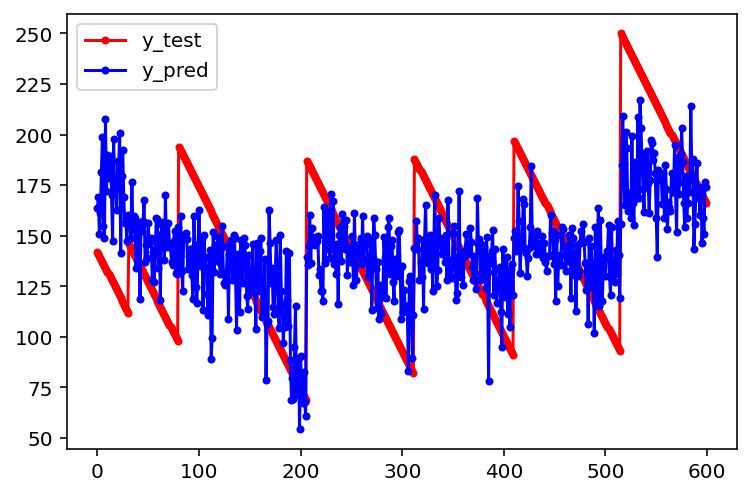

In [28]:
rfr = RandomForestRegressor(50)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_regression_result(y_test, y_pred, 600)

MAE= 34.3426
rmse= 45.8518
max error= 212.5546
R2= 0.3956


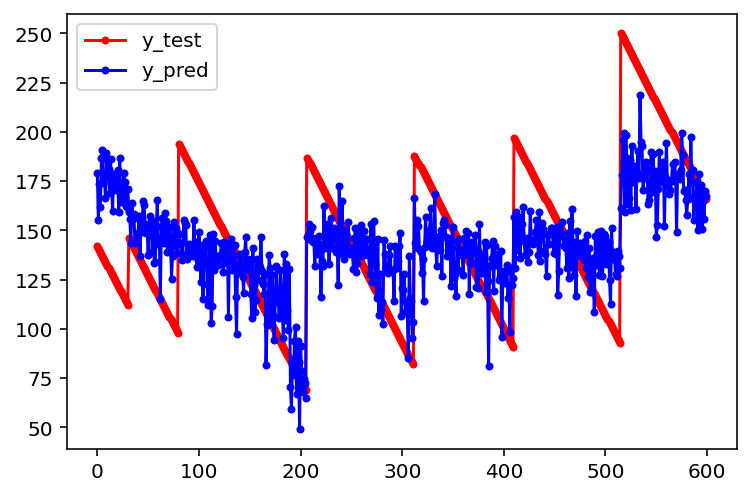

In [26]:
lgbm_r = LGBMRegressor(n_estimators=300)
lgbm_r.fit(X_train, y_train, eval_set=(X_test, y_test), 
           early_stopping_rounds=20, verbose=False)
y_pred = lgbm_r.predict(X_test)
show_regression_result(y_test, y_pred,600)

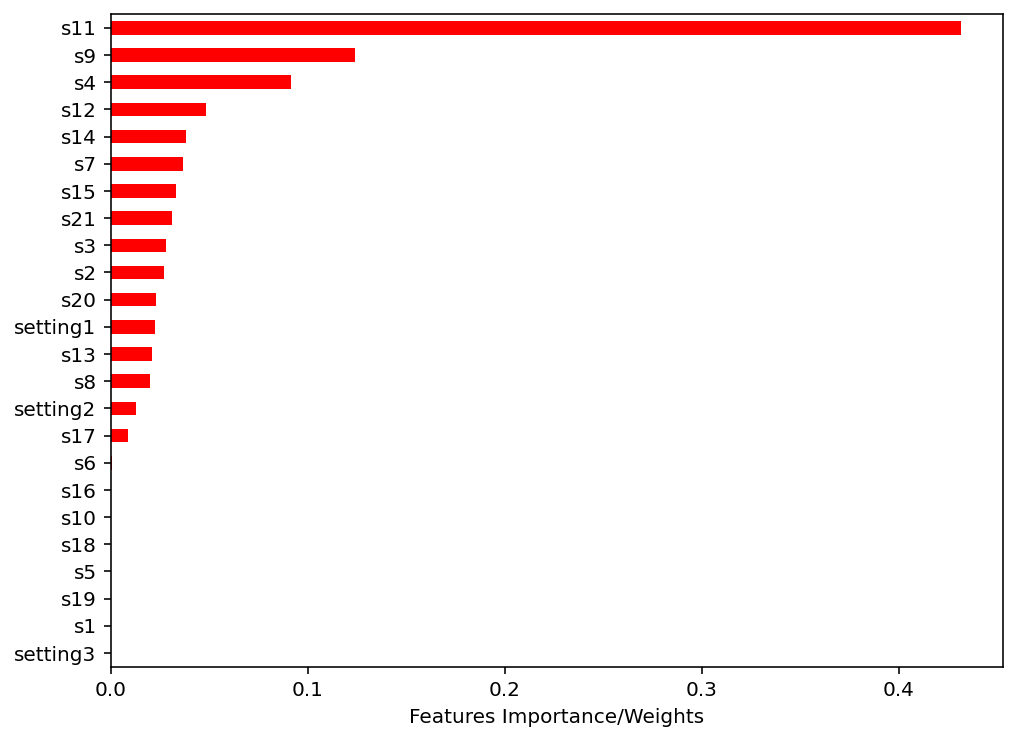

In [29]:
plot_features_weights(X_train.columns, rfr.feature_importances_)

## 분류 모델

In [30]:
y_train = train_df['label1']
y_test = test_df['label1']

In [31]:
def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [32]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [33]:
show_clf_result(y_test, y_pred)

[[12717    47]
 [  129   203]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12764
           1       0.81      0.61      0.70       332

    accuracy                           0.99     13096
   macro avg       0.90      0.80      0.85     13096
weighted avg       0.99      0.99      0.99     13096



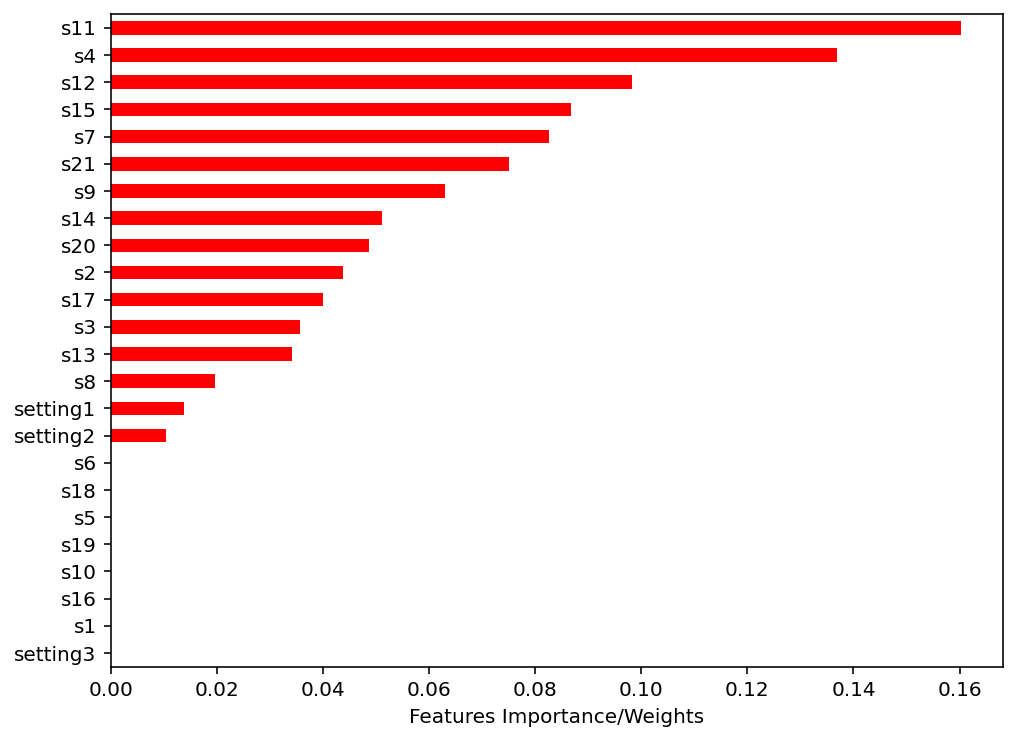

In [34]:
plot_features_weights(X_train.columns, rfc.feature_importances_)

## 분류 기준 시점 선택

- 분류의 경우 분류 기준 시점 선택이 중요하다
 - 고객이 요구하는 시점으로 선택
 - 성능이 가장 잘 나오는 시점을 선택 (실험으로 확인) (성능: 정확도, 리콜, 정밀도, f1 점수 등) 



## 특성 추가 
- 이동평균, 이동분산 등의 컬럼을 추가해본다


In [35]:
def rolling_average(df, window):
    df_av = df.rolling(window, min_periods=1).mean()
    df_av.columns = [col + "_av" + str(window) for col in df.columns]
    return df_av
def rolling_std(df, window):
    df_std = df.rolling(window, min_periods=1).std().fillna(0)
    df_std.columns = [col + "_std" + str(window) for col in df.columns]
    return df_std

- 훈련데이터 특성 추가

In [37]:
window = 10
add1 = rolling_average(X_train, window)
add2 = rolling_std(X_train, window)
X_train_ext = pd.concat((X_train, add1, add2), axis=1)
X_train_ext.shape

(20631, 72)

- 테스트 데이터 특성 추가

In [38]:
add1 = rolling_average(X_test, window)
add2 = rolling_std(X_test, window)
X_test_ext = pd.concat((X_test, add1, add2), axis=1)
X_test_ext.shape

(13096, 72)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- s10_av5
- s10_std5
- s11_av5
- s11_std5
- s12_av5
- ...
Feature names seen at fit time, yet now missing:
- s10_av15
- s10_std15
- s11_av15
- s11_std15
- s12_av15
- ...

  warnings.warn(message, FutureWarning)


MAE= 37.2611
rmse= 49.0798
max error= 214.91
R2= 0.3075


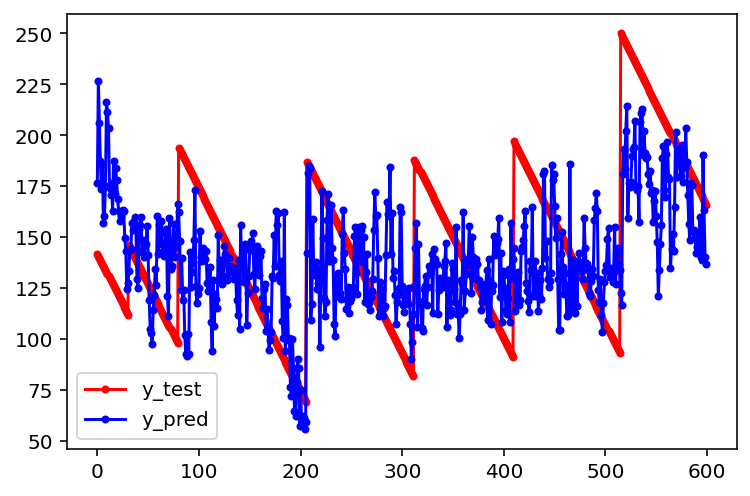

In [65]:
# y_train = train_df['RUL']
# y_test = test_df['RUL']
# rfr = RandomForestRegressor()
# rfr.fit(X_train_ext, y_train)
# y_pred = rfr.predict(X_test_ext)
# show_regression_result(y_test, y_pred, 600)

MAE= 36.2955
rmse= 48.4733
max error= 211.9351
R2= 0.3245


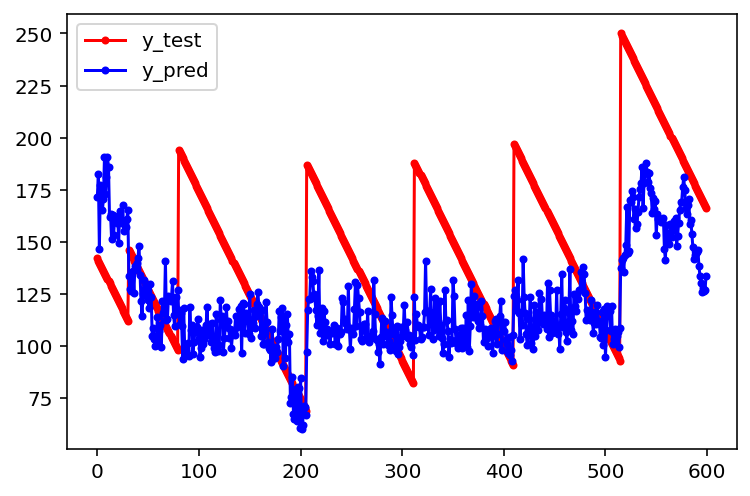

In [39]:
y_train = train_df['RUL']
y_test = test_df['RUL']
lgbm_r = LGBMRegressor(n_estimators=300)
lgbm_r.fit(X_train_ext, y_train, eval_set=(X_test_ext, y_test), 
           early_stopping_rounds=20, verbose=False)
y_pred = lgbm_r.predict(X_test_ext)
show_regression_result(y_test, y_pred,600)

# LSTM 사용

- LSTM 윈도우를 충분히 크게 잡으면 윈도우 내의 중요한 신호를 파악하여 사용할 수 있다
- 장단기 신호를 전파할 수 있다.
- 단순히 이동평균을 사용하면 하나의 정보만 남게되어 스무딩된다

## 임의의 시퀀스를 n_steps 크기로 나누는 함수

- (주의) 아래 함수는 마지막 샘플은 포함하지 않는다
- 현재 데이터로 현재를 예측하는 것이 맞는지는 응용에 따라서 점검해야 한다

In [40]:
def split_seq(sequence, n_steps):
  x = []
  for i in range(len(sequence)- n_steps):
    x.append(sequence[i:i+ n_steps])
  return np.array(x)

In [41]:
# 예제
x = np.arange(21).reshape(-1,3)
split_seq(x,5)

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14]],

       [[ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]]])

- LSTM 신경망은 (samples, time steps, features) 구조의 입력를 필요로 한다

## 입력 시퀀스 만들기

In [42]:
n_steps = 50
res = []
for id in train_df['id'].unique():
  res.append(split_seq(train_df[train_df['id']==id][features], n_steps))
seq_array = np.concatenate(res)
seq_array.shape

(15631, 50, 24)

## 회귀 모델

In [43]:
# 회귀 레이블 얻기
res2 = []
label = ["RUL"]
for id in train_df['id'].unique():
  res2.append(train_df[train_df['id']==id][label][n_steps:len(train_df)])
label_array = np.concatenate(res2)
label_array.shape

(15631, 1)

- r2 값을 모니터링한다

In [44]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [45]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(n_steps, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out))
model.add(Activation("linear"))

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50000     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 80,251
Trainable params: 80,251
Non-traina

In [47]:
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='min')])

print(history.history.keys())

Epoch 1/100
75/75 - 23s - loss: 8642.4121 - mae: 74.1719 - r2_keras: -1.6589e+00 - val_loss: 8037.2817 - val_mae: 71.1693 - val_r2_keras: -2.3702e+00 - 23s/epoch - 303ms/step
Epoch 2/100
75/75 - 21s - loss: 7947.9146 - mae: 70.1614 - r2_keras: -1.4525e+00 - val_loss: 7522.3242 - val_mae: 68.1822 - val_r2_keras: -2.1277e+00 - 21s/epoch - 275ms/step
Epoch 3/100
75/75 - 20s - loss: 7444.1680 - mae: 67.2657 - r2_keras: -1.3024e+00 - val_loss: 7035.1099 - val_mae: 65.3749 - val_r2_keras: -1.9001e+00 - 20s/epoch - 270ms/step
Epoch 4/100
75/75 - 17s - loss: 6974.2480 - mae: 64.5824 - r2_keras: -1.1503e+00 - val_loss: 6579.5791 - val_mae: 62.7681 - val_r2_keras: -1.6893e+00 - 17s/epoch - 222ms/step
Epoch 5/100
75/75 - 16s - loss: 6527.2725 - mae: 62.0469 - r2_keras: -1.0110e+00 - val_loss: 6153.0122 - val_mae: 60.3455 - val_r2_keras: -1.4941e+00 - 16s/epoch - 210ms/step
Epoch 6/100
75/75 - 16s - loss: 6110.6904 - mae: 59.7418 - r2_keras: -8.8215e-01 - val_loss: 5753.8271 - val_mae: 58.0983 - v

In [48]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)

79/79 [==============================] - 7s 75ms/step


In [49]:
def show_mae(history):
    plt.plot(history.history['mae'], 'r', label='mae')
    plt.plot(history.history['val_mae'], 'b', label='val_mae')
    plt.ylim(0)
    plt.legend()
    plt.show()
def show_r2(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['r2_keras'], 'r--', label='train_r2')
    plt.plot(history.history['val_r2_keras'], 'b--', label='val_r2')
    plt.ylim(0)
    plt.legend()
    plt.show()

MAE= 14.804599795382064
rmse= 23.114054557307263
max error= 145.8911590576172
R2= 0.8363785399481286


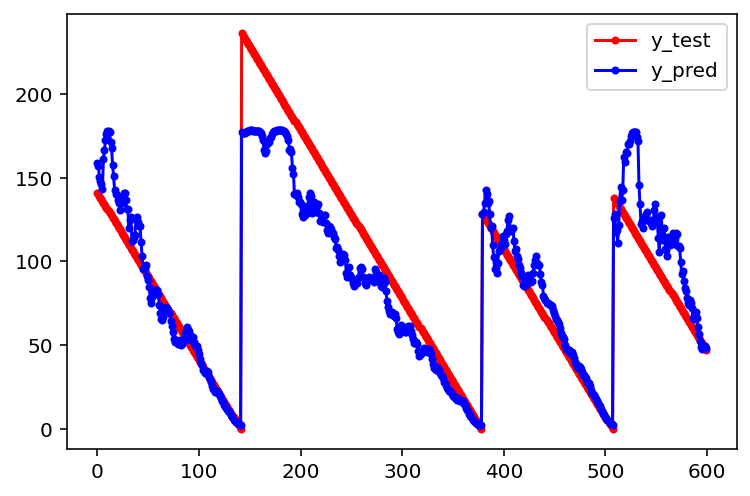

In [60]:
show_regression_result(label_array.ravel(), y_pred.ravel(),600)

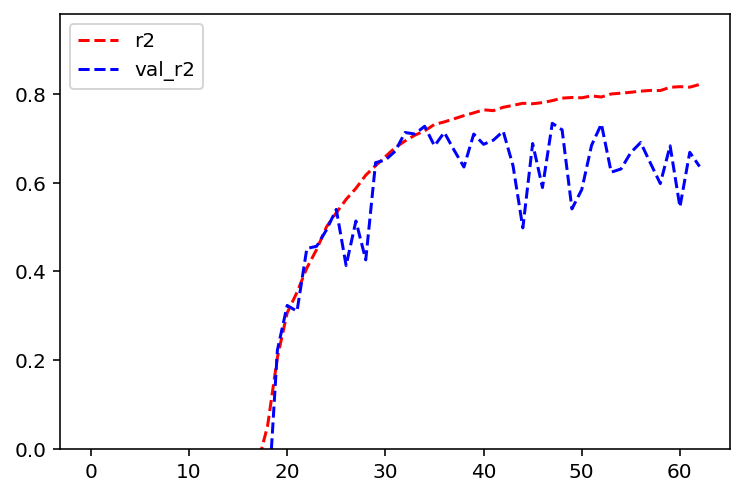

In [55]:
show_r2(history)

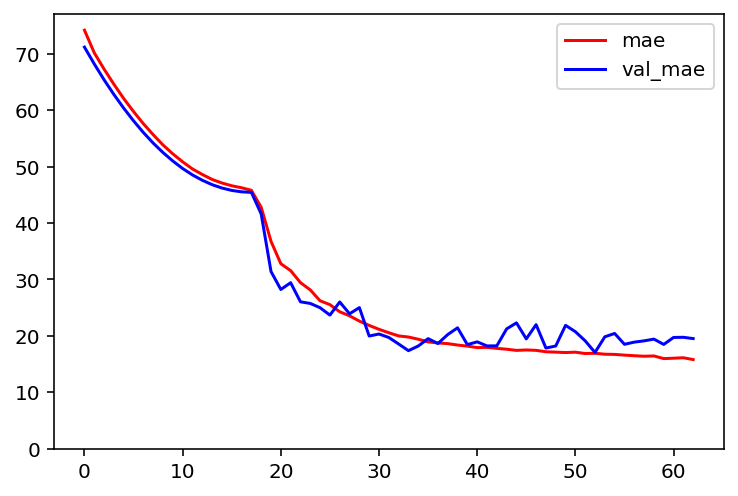

In [56]:
show_mae(history)

## 테스트 데이터에 적용
- 테스트 데이터의 각 엔진별 마지막 50 샘플을 입력으로 사용한다
- 마지막 샘플수가 50보다 작은 경우는 테스트할 수 없다

In [79]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

In [81]:
# test_df의 마지막 샘플의 크기가 50 이상인지를 확인
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

In [82]:
len(y_mask), np.array(y_mask).sum()

(100, 93)

- 회귀 레이블 얻기

In [83]:
test_df.groupby('id')['RUL'].nth(-1)[y_mask].values

array([ 69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,  83,  84,
        50,  28,  87,  16,  57, 113,  20, 119,  66,  97,  90, 115,   8,
        48, 106,   7,  11,  19,  21,  50,  28,  18,  10,  59, 109, 114,
        47, 135,  92,  21,  79, 114,  29,  26,  97, 137,  15, 103,  37,
       114, 100,  21,  54,  72,  28, 128,  14,  77,   8, 121,  94, 118,
        50, 131, 126, 113,  10,  34, 107,  63,  90,   8,   9, 137,  58,
        89, 116, 115, 136,  28,  38,  20,  85,  55, 128, 137,  82,  59,
       117,  20])

In [84]:
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

(93, 1)

In [85]:
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 1)


In [89]:
# 회귀 성능
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('mae=', scores_test[1], 'r2=', scores_test[2])

3/3 - 0s - loss: 391.5233 - mae: 12.6647 - r2_keras: 0.7709 - 49ms/epoch - 16ms/step
mae 12.664711952209473 r2 0.7708774209022522


## 이진 분류 모델

In [ ]:
# 이진분류 레이블 얻기
res2 = []
label = ["label1"]
for id in train_df['id'].unique():
  res2.append(train_df[train_df['id']==id][label][n_steps:len(train_df)])
label_array = np.concatenate(res2)
label_array.shape

(15631, 1)

## LSTM 모델

In [ ]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=nb_out, activation='sigmoid'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
%%time
# fit the network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(seq_array, label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
75/75 [==============================] - 35s 329ms/step - loss: 0.2498 - accuracy: 0.8982 - val_loss: 0.0712 - val_accuracy: 0.9770
Epoch 2/10
75/75 [==============================] - 18s 244ms/step - loss: 0.0895 - accuracy: 0.9636 - val_loss: 0.0407 - val_accuracy: 0.9821
CPU times: user 1min 7s, sys: 4.25 s, total: 1min 12s
Wall time: 53.1 s


In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Accurrac=', scores[1])

79/79 [==============================] - 7s 85ms/step - loss: 0.0673 - accuracy: 0.9726
Accurracy: 0.9725545644760132


In [ ]:
# 이진 분류 확률을 얻는다
y_pred_test = model.predict(seq_array_test_last)
y_true_test = label_array_test_last
show_clf_result(y_true_test, y_pred_test>0.5)

79/79 [==============================] - 7s 85ms/step


array([[12207,   324],
       [  105,  2995]])